In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sports-classification/EfficientNetB0-100-(224 X 224)- 98.40.h5
/kaggle/input/sports-classification/sports.csv
/kaggle/input/sports-classification/valid/bobsled/5.jpg
/kaggle/input/sports-classification/valid/bobsled/1.jpg
/kaggle/input/sports-classification/valid/bobsled/4.jpg
/kaggle/input/sports-classification/valid/bobsled/3.jpg
/kaggle/input/sports-classification/valid/bobsled/2.jpg
/kaggle/input/sports-classification/valid/hurdles/5.jpg
/kaggle/input/sports-classification/valid/hurdles/1.jpg
/kaggle/input/sports-classification/valid/hurdles/4.jpg
/kaggle/input/sports-classification/valid/hurdles/3.jpg
/kaggle/input/sports-classification/valid/hurdles/2.jpg
/kaggle/input/sports-classification/valid/snow boarding/5.jpg
/kaggle/input/sports-classification/valid/snow boarding/1.jpg
/kaggle/input/sports-classification/valid/snow boarding/4.jpg
/kaggle/input/sports-classification/valid/snow boarding/3.jpg
/kaggle/input/sports-classification/valid/snow boarding/2.jpg
/kaggl

In [2]:
!pip install torch torchvision

In [3]:
import sys
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [4]:
data_dirname = '../input/sports-classification'
print(os.listdir(data_dirname))

['EfficientNetB0-100-(224 X 224)- 98.40.h5', 'sports.csv', 'valid', 'test', 'train']


In [5]:
input_shape = (224, 224)
num_labels = 100
workers = os.cpu_count()
batch_size = 32

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [7]:
train_dataset = ImageFolder(root=data_dirname + '/train', transform=train_transform)
valid_dataset = ImageFolder(root=data_dirname + '/valid', transform=valid_transform)
test_dataset = ImageFolder(root=data_dirname + '/test', transform=valid_transform)


In [8]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 13492
    Root location: ../input/sports-classification/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [9]:
valid_dataset

Dataset ImageFolder
    Number of datapoints: 500
    Root location: ../input/sports-classification/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [10]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 500
    Root location: ../input/sports-classification/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [11]:
classes = train_dataset.classes;
print(f'Number of classes: {len(classes)}')
print(classes)

Number of classes: 100
['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'r

In [12]:
img, label = train_dataset[1000]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 7


tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [14]:
def show_images(img, label, dataset=train_dataset):
    print('Label: ', dataset.classes[label], "= "+str(label))
    plt.imshow(img.permute(1,2,0))  #change dimension of tensor for matplotlib 

Label:  ampute football = 1


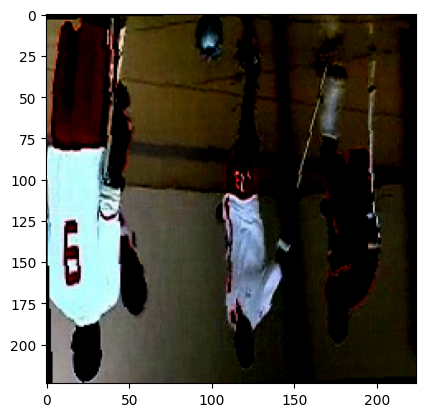

In [15]:
# img, label = dataset[0]
# show_images(img, label)

show_images(*train_dataset[147])

In [16]:
# training, validation and test loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=True,
    drop_last=False,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=False,
    drop_last=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=False,
    drop_last=False,
)

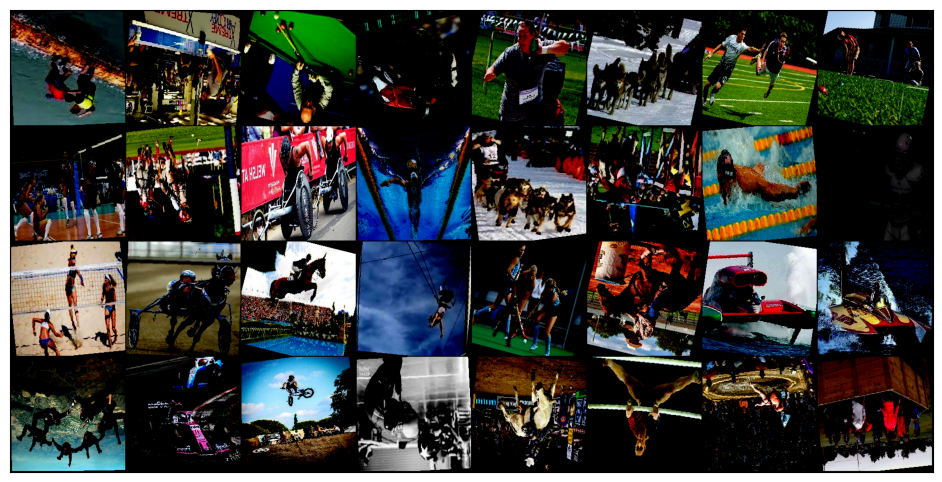

In [17]:
from torchvision.utils import make_grid

def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1,2,0))
        break
        

show_batch(train_loader)

In [18]:
def train_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
   
    model.train()

    losses = []
    accuracies = []

    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:
            x_batch = x_batch.to(device)
            y_true = y_true.to(device)

            optimizer.zero_grad()
    
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_true)
            
            loss.backward()

            losses.append(loss.item())
            accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

            progress.set_postfix_str(f"loss {losses[-1]:.4f}")

            # update the optimizer parameters
            optimizer.step()

            progress.update(1)

    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }

    return logs

In [19]:
@torch.inference_mode()
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:

    model.eval()

    losses = []
    accuracies = []

    for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
        x_batch = x_batch.to(device)
        y_true = y_true.to(device)

        y_pred = model(x_batch)
        loss = criterion(y_pred, y_true)

        losses.append(loss.item())
        accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }

    return logs

In [20]:
def save_model(file_name, epoch, n_epochs, model, optimizer, train_loss, train_accuracy, valid_loss, valid_accuracy):
    model_checkpoint = {
                 "model_state_dict": model.state_dict(),
                 "optimizer_state_dict": optimizer.state_dict(),
                 "epoch": epoch,
                 "num_epochs": n_epochs,
                 "metrics": {
                    "training": {"loss": train_loss, "accuracy": train_accuracy},
                    "validation": {"loss": valid_loss, "accuracy": valid_accuracy},
                 },
    }
    torch.save(model_checkpoint, f'/kaggle/working/{file_name}')

In [21]:
def best_model_selection(model_name: str, model, train_loader, valid_loader, loss_fn, optimizer, device):
    num_epochs = 20

    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    
    best_score = float("-inf")

    for epochs in range(num_epochs):
        print(f"Epoch {epochs}/{num_epochs} \n")

        train_logs = train_epoch(model, train_loader, loss_fn, optimizer, device, verbose=True)
        train_losses.append(np.mean(train_logs["losses"]))
        train_accuracies.append(np.mean(train_logs["accuracies"]))
        print("loss:    ", train_losses[-1])
        print("accuracy:", train_accuracies[-1])


        valid_logs = evaluate_model(model, valid_loader, loss_fn, device, verbose=True)
        valid_losses.append(np.mean(valid_logs["losses"]))
        valid_accuracies.append(np.mean(valid_logs["accuracies"]))
        print("loss:    ", valid_losses[-1])
        print("accuracy:", valid_accuracies[-1])
        
        scheduler.step(valid_losses[-1])
        
        # save the trained model weights
        file_name = f'best_{model_name}.pth'
        if valid_accuracies[-1] >= best_score:
            save_model(file_name, epochs + 1, num_epochs, model, optimizer, train_losses[-1], train_accuracies[-1], valid_losses[-1], valid_accuracies[-1])
            best_score = valid_accuracies[-1]

    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [22]:
def plot_accuracies(train_accuracies,valid_accuracies):
    plt.plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
    plt.plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
    plt.legend(["train", "validation"])
    plt.grid();

In [23]:
def plot_losses(train_losses, valid_loses):
    plt.plot(np.arange(len(train_losses)), train_losses, ".-")
    plt.plot(np.arange(len(valid_losses)), valid_losses, ".-")
    plt.legend(["train", "validation"])
    plt.grid()

In [24]:
torch.cuda.is_available()

True

In [25]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [26]:
device = get_default_device()
device

device(type='cuda')

# ***Transfer Learning***

> ***ResNet50***

In [28]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
torch.manual_seed(42)
model.fc = nn.Linear(model.fc.in_features, num_labels)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses, train_accuracies, valid_losses, valid_accuracies = best_model_selection('resnet50', model, train_loader, valid_loader, loss_fn, optimizer, device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s] 


Number of trainable parameters - 23712932
Epoch 0/20 

training: 100%|██████████████████████████████████████| 422/422 [02:10<00:00,  3.25it/s, loss 0.9143]
loss:     1.945357552283748
accuracy: 0.57997334
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.39it/s]
loss:     0.4206498768180609
accuracy: 0.898
Epoch 1/20 

training: 100%|██████████████████████████████████████| 422/422 [02:16<00:00,  3.09it/s, loss 0.1936]
loss:     0.4290720340553053
accuracy: 0.8917877
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]
loss:     0.17143654357641935
accuracy: 0.948
Epoch 2/20 

training: 100%|██████████████████████████████████████| 422/422 [02:17<00:00,  3.07it/s, loss 0.1698]
loss:     0.23215535882048274
accuracy: 0.9418915
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]
loss:     0.13511538470629603
accuracy: 0.962
Epoch 3/20 

training: 100%|

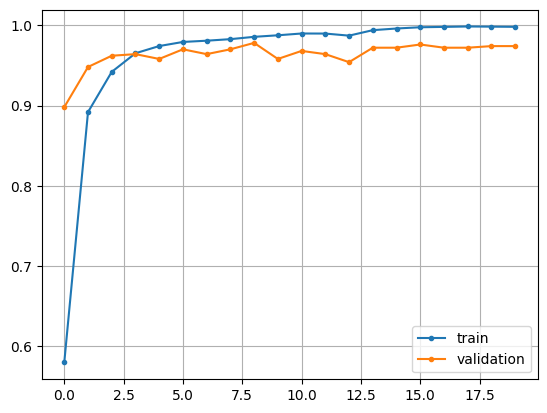

In [29]:
plot_accuracies(train_accuracies, valid_accuracies)

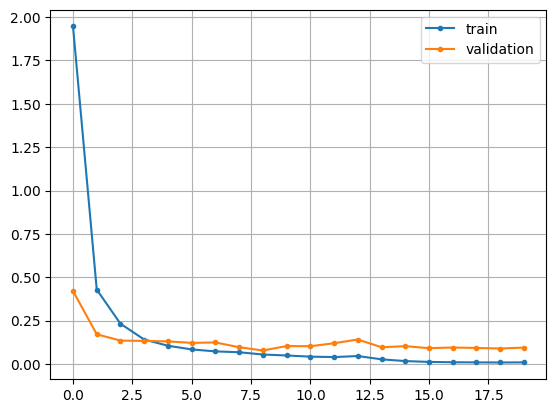

In [30]:
plot_losses(train_losses, valid_losses)

In [31]:
best_state = torch.load('/kaggle/working/best_resnet50.pth')
print(best_state['epoch'])
print(best_state['metrics'])

9
{'training': {'loss': 0.05492345849327937, 'accuracy': 0.985547}, 'validation': {'loss': 0.07811248325742781, 'accuracy': 0.978}}


> ***AlexNet***

In [58]:
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
torch.manual_seed(42)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_labels)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses, train_accuracies, valid_losses, valid_accuracies = best_model_selection('alexnet', model, train_loader, valid_loader, loss_fn, optimizer, device)

Number of trainable parameters - 57413540
Epoch 0/20 

training: 100%|██████████████████████████████████████| 422/422 [00:21<00:00, 19.45it/s, loss 1.5072]
loss:     2.28878488444604
accuracy: 0.41572782
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.71it/s]
loss:     1.00315161049366
accuracy: 0.708
Epoch 1/20 

training: 100%|██████████████████████████████████████| 422/422 [00:21<00:00, 19.43it/s, loss 2.1235]
loss:     1.1995113693283632
accuracy: 0.65750074
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.52it/s]
loss:     0.7343659307807684
accuracy: 0.786
Epoch 2/20 

training: 100%|██████████████████████████████████████| 422/422 [00:21<00:00, 19.57it/s, loss 1.4277]
loss:     0.9031376620463285
accuracy: 0.7301364
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.21it/s]
loss:     0.7632736079394817
accuracy: 0.774
Epoch 3/20 

training: 100%|█████

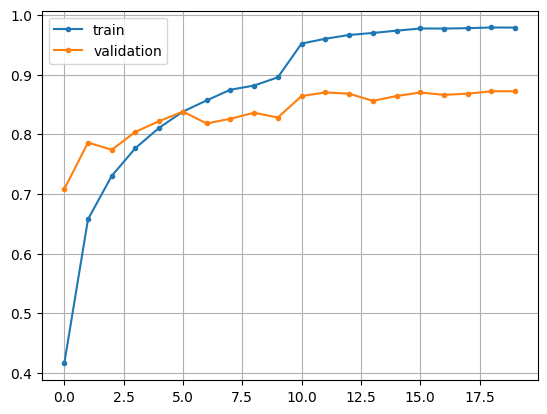

In [59]:
plot_accuracies(train_accuracies, valid_accuracies)

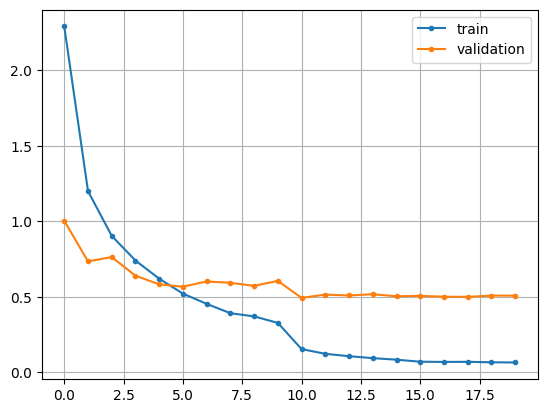

In [60]:
plot_losses(train_losses, valid_losses)

In [61]:
best_state = torch.load('/kaggle/working/best_alexnet.pth')
print(best_state['epoch'])
print(best_state['metrics'])

20
{'training': {'loss': 0.06554564443180752, 'accuracy': 0.9787281}, 'validation': {'loss': 0.5076164508209331, 'accuracy': 0.872}}


> ***VGG16***

In [28]:
model = models.vgg13(weights=models.VGG13_Weights.IMAGENET1K_V1)
torch.manual_seed(42)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_labels)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses, train_accuracies, valid_losses, valid_accuracies = best_model_selection('vgg13', model, train_loader, valid_loader, loss_fn, optimizer, device)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:16<00:00, 31.9MB/s] 


Number of trainable parameters - 129360548
Epoch 0/20 

training: 100%|██████████████████████████████████████| 422/422 [02:47<00:00,  2.52it/s, loss 1.5847]
loss:     2.972092972971252
accuracy: 0.27156833
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.48it/s]
loss:     1.178068332374096
accuracy: 0.676
Epoch 1/20 

training: 100%|██████████████████████████████████████| 422/422 [02:51<00:00,  2.46it/s, loss 1.3619]
loss:     1.2839472612357252
accuracy: 0.6387489
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.67it/s]
loss:     0.5851479079574347
accuracy: 0.828
Epoch 2/20 

training: 100%|██████████████████████████████████████| 422/422 [02:51<00:00,  2.46it/s, loss 0.6865]
loss:     0.8393335786617198
accuracy: 0.7590424
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.73it/s]
loss:     0.5191017743200064
accuracy: 0.862
Epoch 3/20 

training: 100%|███

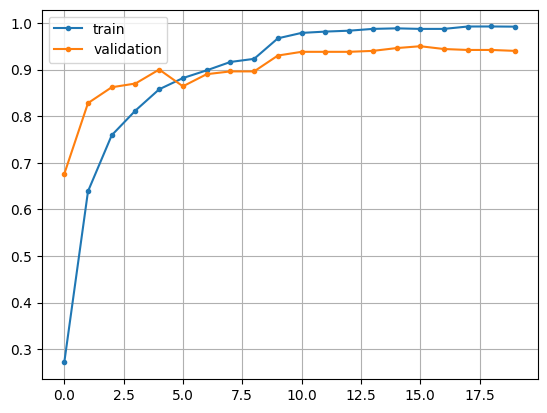

In [29]:
plot_accuracies(train_accuracies, valid_accuracies)

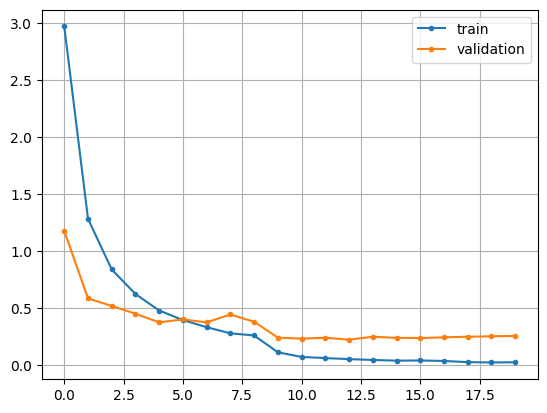

In [30]:
plot_losses(train_losses, valid_losses)

In [31]:
best_state = torch.load('/kaggle/working/best_vgg13.pth')
print(best_state['epoch'])
print(best_state['metrics'])

16
{'training': {'loss': 0.040786099698992065, 'accuracy': 0.9871776}, 'validation': {'loss': 0.23774756785860518, 'accuracy': 0.95}}


> ***DenseNet161***

In [93]:
model = models.densenet161(weights=models.DenseNet161_Weights.IMAGENET1K_V1)
torch.manual_seed(42)
model.classifier = nn.Linear(model.classifier.in_features, num_labels)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses, train_accuracies, valid_losses, valid_accuracies = best_model_selection('densenet161', model, train_loader, valid_loader, loss_fn, optimizer, device)

Number of trainable parameters - 26692900
Epoch 0/20 

training: 100%|██████████████████████████████████████| 422/422 [04:50<00:00,  1.45it/s, loss 0.8959]
loss:     2.127515920530563
accuracy: 0.5848651
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.21it/s]
loss:     0.606780007481575
accuracy: 0.882
Epoch 1/20 

training: 100%|██████████████████████████████████████| 422/422 [04:49<00:00,  1.46it/s, loss 0.7116]
loss:     0.6333644769697393
accuracy: 0.86732876
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.26it/s]
loss:     0.2826364282518625
accuracy: 0.93
Epoch 2/20 

training: 100%|██████████████████████████████████████| 422/422 [04:49<00:00,  1.46it/s, loss 0.3910]
loss:     0.32177346035555643
accuracy: 0.93107027
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.21it/s]
loss:     0.19315476529300213
accuracy: 0.946
Epoch 3/20 

training: 100%|██

20
{'training': {'loss': 0.0064199638740000675, 'accuracy': 0.9991106}, 'validation': {'loss': 0.1039624952027225, 'accuracy': 0.97}}


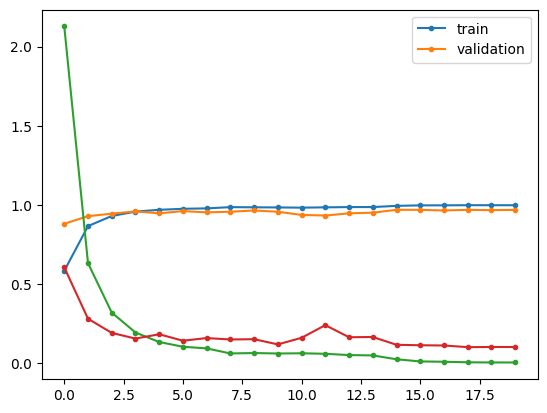

In [94]:
plot_accuracies(train_accuracies, valid_accuracies)

plot_losses(train_losses, valid_losses)

best_state = torch.load('/kaggle/working/best_densenet161.pth')
print(best_state['epoch'])
print(best_state['metrics'])

> ***MobileNetV3***

In [33]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
torch.manual_seed(42)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_labels, bias=True)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses, train_accuracies, valid_losses, valid_accuracies = best_model_selection('mobilenet', model, train_loader, valid_loader, loss_fn, optimizer, device)

Number of trainable parameters - 4330132
Epoch 0/20 

training: 100%|██████████████████████████████████████| 422/422 [00:44<00:00,  9.54it/s, loss 0.9693]
loss:     2.3788846484010255
accuracy: 0.47620812
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.86it/s]
loss:     0.6287688352167606
accuracy: 0.842
Epoch 1/20 

training: 100%|██████████████████████████████████████| 422/422 [00:43<00:00,  9.71it/s, loss 0.5005]
loss:     0.652117484800906
accuracy: 0.8206344
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.88it/s]
loss:     0.32183426385745406
accuracy: 0.912
Epoch 2/20 

training: 100%|██████████████████████████████████████| 422/422 [00:43<00:00,  9.68it/s, loss 0.2813]
loss:     0.38267194748066047
accuracy: 0.8912689
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.95it/s]
loss:     0.24310278659686446
accuracy: 0.934
Epoch 3/20 

training: 100%|█

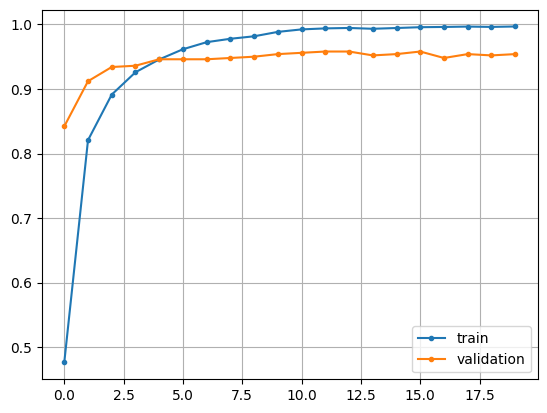

In [34]:
plot_accuracies(train_accuracies, valid_accuracies)





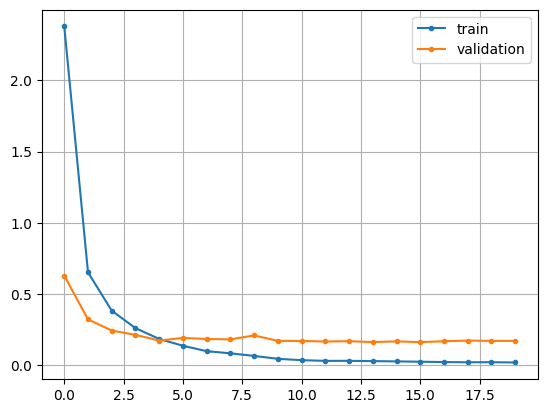

In [35]:
plot_losses(train_losses, valid_losses)

In [36]:
best_state = torch.load('/kaggle/working/best_mobilenet.pth')
print(best_state['epoch'])
print(best_state['metrics'])

16
{'training': {'loss': 0.02411020581524431, 'accuracy': 0.99570113}, 'validation': {'loss': 0.16182551105157472, 'accuracy': 0.958}}


> ***InceptionV3***

In [54]:
train_transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

valid_transform_inception = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [55]:
train_ds = ImageFolder(root=data_dirname + '/train', transform=train_transform_inception)
valid_ds = ImageFolder(root=data_dirname + '/valid', transform=valid_transform_inception)
test_ds = ImageFolder(root=data_dirname + '/test', transform=valid_transform_inception)

In [56]:
# training, validation and test loaders for inception model
train_loader_inception = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=True,
    drop_last=False,
)

valid_loader_inception = DataLoader(
    valid_ds,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=False,
    drop_last=False,
)

test_loader_inception = DataLoader(
    test_ds,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=False,
    drop_last=False,
)

In [57]:
model = models.inception_v3(pretrained=True, aux_logits=True)
torch.manual_seed(42)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_labels)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)
train_losses, train_accuracies, valid_losses, valid_accuracies = best_model_selection('inception_v3', model, train_loader_inception, valid_loader_inception, loss_fn, optimizer, device)

Number of trainable parameters - 25317164
Epoch 0/20 

training:   0%|                                                             | 0/422 [00:00<?, ?it/s]


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not InceptionOutputs

In [62]:
def train_epoch_inception(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
   
    model.train()

    losses = []
    accuracies = []

    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:
            x_batch = x_batch.to(device)
            y_true = y_true.to(device)

            optimizer.zero_grad()
    
            # Forward pass
            outputs = model(x_batch)
            y_pred = outputs.logits  # Extract the tensor containing predicted class scores

            # Calculate loss
            loss = criterion(y_pred, y_true)
            
            # Backpropagation
            loss.backward()

            losses.append(loss.item())
            accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

            progress.set_postfix_str(f"loss {losses[-1]:.4f}")

            # Update the optimizer parameters
            optimizer.step()

            progress.update(1)

    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }

    return logs


In [63]:
def best_model_selection_inception(model_name: str, model, train_loader, valid_loader, loss_fn, optimizer, device):
    num_epochs = 20

    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    
    best_score = float("-inf")

    for epochs in range(num_epochs):
        print(f"Epoch {epochs}/{num_epochs} \n")

        train_logs = train_epoch_inception(model, train_loader, loss_fn, optimizer, device, verbose=True)
        train_losses.append(np.mean(train_logs["losses"]))
        train_accuracies.append(np.mean(train_logs["accuracies"]))
        print("loss:    ", train_losses[-1])
        print("accuracy:", train_accuracies[-1])


        valid_logs = evaluate_model(model, valid_loader, loss_fn, device, verbose=True)
        valid_losses.append(np.mean(valid_logs["losses"]))
        valid_accuracies.append(np.mean(valid_logs["accuracies"]))
        print("loss:    ", valid_losses[-1])
        print("accuracy:", valid_accuracies[-1])
        
        scheduler.step(valid_losses[-1])
        
        # save the trained model weights
        file_name = f'best_{model_name}.pth'
        if valid_accuracies[-1] >= best_score:
            save_model(file_name, epochs + 1, num_epochs, model, optimizer, train_losses[-1], train_accuracies[-1], valid_losses[-1], valid_accuracies[-1])
            best_score = valid_accuracies[-1]

    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [65]:
# InceptionV3
model = models.inception_v3(pretrained=True, aux_logits=True)
torch.manual_seed(42)
# Adjust the input size to 299x299
input_size = 299
# Modify the first convolutional layer to accept the new input size
model.Conv2d_1a_3x3.padding = (input_size - 299) // 2
# Modify the average pooling layer to adapt to the new input size
model.AuxLogits.fc = nn.Linear(768, num_labels)  # Adjust the number of output features accordingly
model.fc = nn.Linear(2048, num_labels)  # Adjust the number of output features accordingly
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)
train_losses, train_accuracies, valid_losses, valid_accuracies = best_model_selection_inception('inception_v3', model, train_loader_inception, valid_loader_inception, loss_fn, optimizer, device)

Number of trainable parameters - 24625064
Epoch 0/20 

training: 100%|██████████████████████████████████████| 422/422 [03:08<00:00,  2.24it/s, loss 1.3490]
loss:     2.4604138976307275
accuracy: 0.4884376
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.91it/s]
loss:     0.8845061548054218
accuracy: 0.744
Epoch 1/20 

training: 100%|██████████████████████████████████████| 422/422 [03:08<00:00,  2.24it/s, loss 1.0772]
loss:     0.7469421929516499
accuracy: 0.8234509
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.50it/s]
loss:     0.8092513671144843
accuracy: 0.776
Epoch 2/20 

training: 100%|██████████████████████████████████████| 422/422 [03:08<00:00,  2.23it/s, loss 0.4705]
loss:     0.4061482472265784
accuracy: 0.89734656
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.47it/s]
loss:     0.49771575536578894
accuracy: 0.848
Epoch 3/20 

training: 100%|█

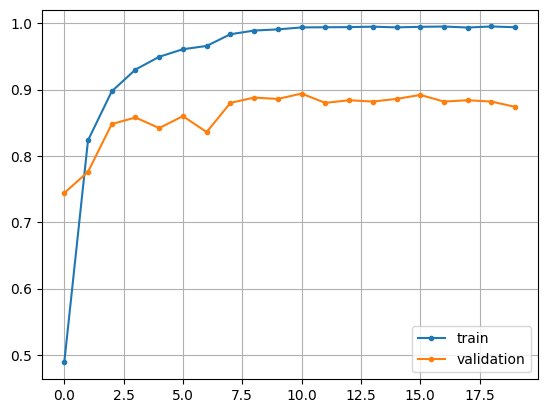

In [66]:
plot_accuracies(train_accuracies, valid_accuracies)





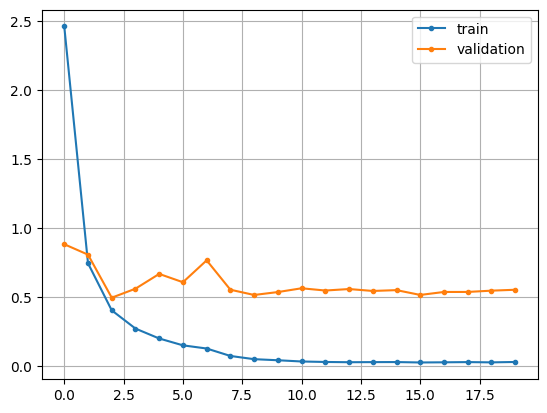

In [67]:
plot_losses(train_losses, valid_losses)

In [68]:
best_state = torch.load('/kaggle/working/best_inception_v3.pth')
print(best_state['epoch'])
print(best_state['metrics'])

11
{'training': {'loss': 0.036012041591046054, 'accuracy': 0.9938482}, 'validation': {'loss': 0.5658146115019917, 'accuracy': 0.894}}


> ***EfficientNetB1***

In [27]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2)
torch.manual_seed(42)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_labels, bias=True)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses, train_accuracies, valid_losses, valid_accuracies = best_model_selection('efficientnet', model, train_loader, valid_loader, loss_fn, optimizer, device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 142MB/s]


Number of trainable parameters - 6641284
Epoch 0/20 

training: 100%|██████████████████████████████████████| 422/422 [01:36<00:00,  4.37it/s, loss 1.5101]
loss:     2.969778831536171
accuracy: 0.40379485
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.10it/s]
loss:     1.0663519985973835
accuracy: 0.8
Epoch 1/20 

training: 100%|██████████████████████████████████████| 422/422 [01:37<00:00,  4.35it/s, loss 0.9336]
loss:     0.9864294901137104
accuracy: 0.7755707
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.57it/s]
loss:     0.3994611520320177
accuracy: 0.912
Epoch 2/20 

training: 100%|██████████████████████████████████████| 422/422 [01:38<00:00,  4.28it/s, loss 0.4080]
loss:     0.5731316674235872
accuracy: 0.86102873
evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.50it/s]
loss:     0.2454414889216423
accuracy: 0.938
Epoch 3/20 

training: 100%|█████

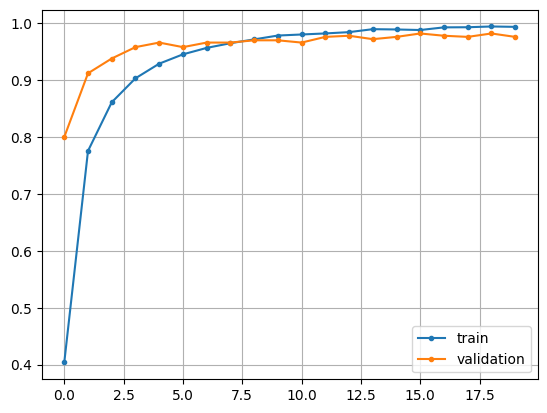

In [28]:
plot_accuracies(train_accuracies, valid_accuracies)

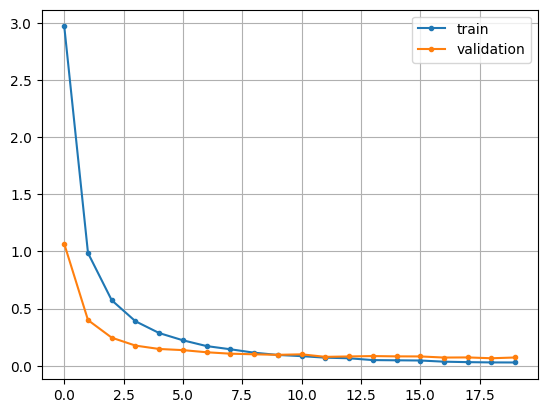

In [29]:
plot_losses(train_losses, valid_losses)

In [30]:
best_state = torch.load('/kaggle/working/best_efficientnet.pth')
print(best_state['epoch'])
print(best_state['metrics'])

19
{'training': {'loss': 0.02891520766863573, 'accuracy': 0.9942929}, 'validation': {'loss': 0.06536206402233802, 'accuracy': 0.982}}


# ***Testing***

In [32]:
model1 = models.efficientnet_b1()
model1.classifier[1] = nn.Linear(model1.classifier[1].in_features, num_labels, bias=True)
model1 = model1.to(device)
best_model1 = torch.load('/kaggle/working/best_efficientnet.pth')
model1.load_state_dict(best_model1['model_state_dict'])
loss_fn = nn.CrossEntropyLoss()

test_logs = evaluate_model(model1, test_loader, loss_fn, device, verbose=True)
test_loss = np.mean(test_logs["losses"])
test_accuracy = np.mean(test_logs["accuracies"])
print("loss: ", test_loss)
print("accuracy: ", test_accuracy)

evaluation: 100%|███████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]
loss:  0.04834664237569086
accuracy:  0.988


# 

# ***Predictions***

In [71]:
df = pd.read_csv(data_dirname + '/sports.csv')
df

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train
...,...,...,...,...
14488,99,valid/wingsuit flying/1.jpg,wingsuit flying,valid
14489,99,valid/wingsuit flying/2.jpg,wingsuit flying,valid
14490,99,valid/wingsuit flying/3.jpg,wingsuit flying,valid
14491,99,valid/wingsuit flying/4.jpg,wingsuit flying,valid


In [73]:
def get_test_image(category: str, number: int):
    image_path = data_dirname + f'/test/{category}/{number}.jpg'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [74]:
def get_class_name(class_id):
    return df.loc[df["class id"] == class_id].iloc[0]["labels"]

In [75]:
# define preprocess transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])  

In [76]:
def image_prediction(model, image, loss_fn, device):
    """
    Function to predict the label of a single image
    """
    
    model.eval()
    image = transform(image)
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image.to(device))
    output_label = torch.topk(outputs, 1)
    print(output_label)
    pred_class_id = int(output_label.indices)
    print(pred_class_id)
    pred_class_name = get_class_name(pred_class_id)
#     pred_class_name = get_class_name(output_label)

    
    return  pred_class_name

In [77]:
model = models.efficientnet_b1()
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_labels, bias=True)
model = model.to(device)
best_model = torch.load('/kaggle/working/best_efficientnet.pth')
model.load_state_dict(best_model['model_state_dict'])
loss_fn = nn.CrossEntropyLoss()

torch.return_types.topk(
values=tensor([[12.1760]], device='cuda:0'),
indices=tensor([[8]], device='cuda:0'))
8
Predicted label:  basketball


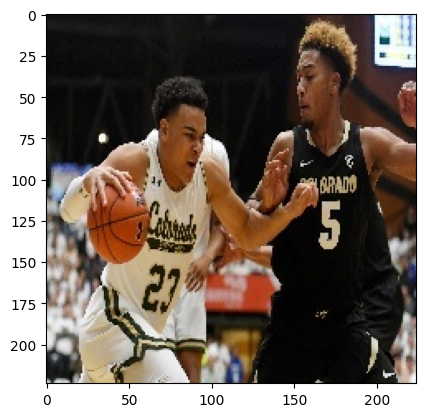

In [78]:
image = get_test_image('basketball', 5)
plt.imshow(image)
pred_label = image_prediction(model, image, loss_fn, device)
print("Predicted label: ", pred_label)

torch.return_types.topk(
values=tensor([[14.3416]], device='cuda:0'),
indices=tensor([[0]], device='cuda:0'))
0
Predicted label:  air hockey


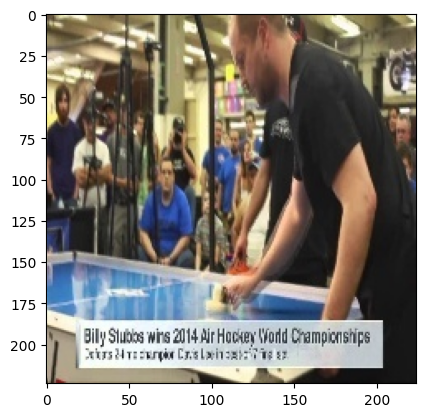

In [79]:
image = get_test_image('air hockey', 5)
plt.imshow(image)
pred_label = image_prediction(model, image, loss_fn, device)
print("Predicted label: ", pred_label)